In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from tensorflow.keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
from sklearn.metrics import accuracy_score


/home/alberto/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('data.csv', delimiter='|')
data.head()

,id,class,content
0,29420,0,"in my opinion , a movie reviewer's most import..."
1,17219,0,"you can watch this movie , that is based on a ..."
2,18406,0,"this is asking a lot to believe , and though i..."
3,18648,0,no heroes and no story are the main attributes...
4,20021,0,"this is not an art movie , yet i saw it an art..."


In [3]:
lemmatizer = WordNetLemmatizer()

In [4]:
'''
#pre-trained embeddings
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip

with open("glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}
'''

'\n#pre-trained embeddings\nwget http://nlp.stanford.edu/data/glove.6B.zip\nunzip glove.6B.zip\n\nwith open("glove.6B.50d.txt", "rb") as lines:\n    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))\n           for line in lines}\n'

In [5]:
def clean_sentences(df):
    reviews = []

    for sent in df['content']:
        
        #remove html content
        review_text = BeautifulSoup(sent, "lxml").get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words if not i in set(stopwords.words('english'))]
        lemma_string=" ".join(lemma_words)
        reviews.append(lemma_string)
        

    return(reviews)

In [6]:
sentences = clean_sentences(data)

In [7]:
y = data.iloc[:, 1].values

In [8]:
data_train, data_test, labels_train, labels_test = train_test_split(sentences, y, test_size=0.20, random_state=42)

In [9]:
'''
######OPT1 word ids for embeddings

unique_words = set()
len_max = 0

for sent in data_train:
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(data_train))
X_train = tokenizer.texts_to_sequences(data_train)
X_test = tokenizer.texts_to_sequences(data_test)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_test.shape)
'''

'\n######OPT1 word ids for embeddings\n\nunique_words = set()\nlen_max = 0\n\nfor sent in data_train:\n    \n    unique_words.update(sent)\n    \n    if(len_max<len(sent)):\n        len_max = len(sent)\n        \n#length of the list of unique_words gives the no of unique words\nprint(len(list(unique_words)))\nprint(len_max)\n\ntokenizer = Tokenizer(num_words=len(list(unique_words)))\ntokenizer.fit_on_texts(list(data_train))\nX_train = tokenizer.texts_to_sequences(data_train)\nX_test = tokenizer.texts_to_sequences(data_test)\n\nX_train = sequence.pad_sequences(X_train, maxlen=len_max)\nX_test = sequence.pad_sequences(X_test, maxlen=len_max)\nprint(X_train.shape,X_test.shape)\n'

In [10]:
###OPT2 tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=12000)
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

In [11]:
from sklearn import svm
clf = svm.SVC(gamma=0.95, C=1.5, decision_function_shape='ovo')
clf.fit(X_train, labels_train)

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.95, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
y_predicted = clf.predict(X_test)

In [13]:
accuracy_score(labels_test, y_predicted)

0.6310679611650486

In [14]:
from confusion_matrix import plot_confusion_matrix

Confusion matrix, without normalization
[[41 32  2]
 [12 75  1]
 [ 2 27 14]]


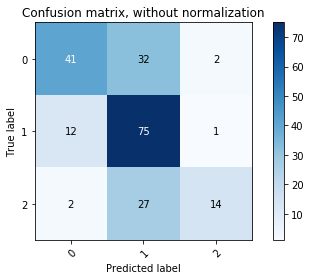

In [15]:
plot_confusion_matrix(labels_test, y_predicted, np.array(('0','1','2')))